In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, 'is_train', 'date']

def filter_feature(path):
    if \
    path.count('') \
    :
#     and not path.count('raw__D') \
#     and not path.count('raw__C') \
#     and not path.count('raw__V') \
#     or path.count('Fraud') 
#     or path.count('tionID') 
#     or path.count('C1')
#     or path.count('C13')
#     or path.count('V232')
#     or path.count('addr1')
        return True
    else:
        return False
    

paths_train = glob('../feature/raw_use/*_train.gz')
paths_train = [path for path in paths_train if filter_feature(path) ]
paths_test = glob('../feature/raw_use/*_test.gz')
paths_test = [path for path in paths_test if filter_feature(path) ]

paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

paths_train_feature += glob('../feature/valid/*_train.gz')
paths_test_feature += glob('../feature/valid/*_test.gz')

In [3]:
df_train = reduce_mem_usage( parallel_load_data(paths_train) )
df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

Memory usage of dataframe is 127.28 MB
Memory usage after optimization is: 120.52 MB
Decreased by 5.3%
Memory usage of dataframe is 327.14 MB
Memory usage after optimization is: 375.46 MB
Decreased by -14.8%


  2%|▏         | 1/61 [00:00<00:06,  8.76it/s]

* Check Unique Feature.


100%|██████████| 61/61 [00:01<00:00, 49.59it/s]


All Features have info.
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.93342
[400]	valid_0's auc: 0.942659
[600]	valid_0's auc: 0.945595
[800]	valid_0's auc: 0.947544
Early stopping, best iteration is:
[942]	valid_0's auc: 0.949008
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.926298
[400]	valid_0's auc: 0.937089
[600]	valid_0's auc: 0.940777
[800]	valid_0's auc: 0.942975
[1000]	valid_0's auc: 0.943508
Early stopping, best iteration is:
[956]	valid_0's auc: 0.943619
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.930432
[400]	valid_0's auc: 0.937813
[600]	valid_0's auc: 0.941975
[800]	valid_0's auc: 0.94367
Early stopping, best iteration is:
[805]	valid_0's auc: 0.943735
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.920981
[400]	valid_0's auc: 0.930797
[600]	valid_0's auc: 0.935192
Early stopping, best iteration is:
[683]	valid_0's auc

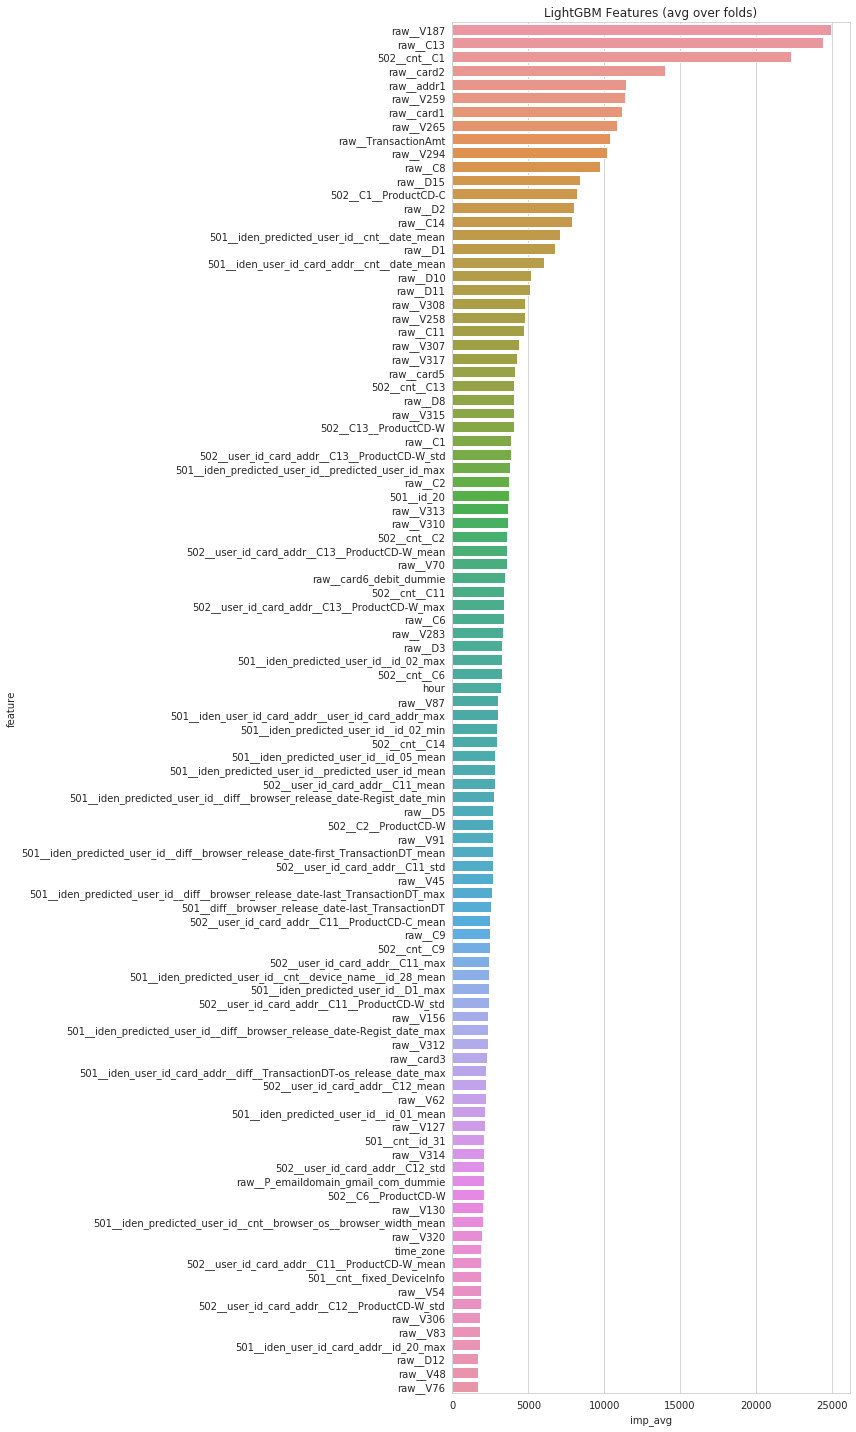

Setup Dataset dim_ml_dataset.


In [4]:
list_feim = []
for i in range(1, 2, 1):
    
#     valid_paths_train = paths_train_feature[i*800:(i+1)*800]
#     valid_paths_test  = paths_test_feature[i*800:(i+1)*800]
    valid_paths_train = paths_train_feature
    valid_paths_test  = paths_test_feature
    
    #========================================================================
    # pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
    #========================================================================
    remove_paths = []
    for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
        if os.path.exists(trn_path) and os.path.exists(tes_path):
            pass
        else:
            remove_paths.append(trn_path)
            remove_paths.append(tes_path)
    for path in remove_paths:
        if path.count('train'):
            valid_paths_train.remove(path)
            print(f'remove {path}')
        elif path.count('test'):
            valid_paths_test.remove(path)
            print(f'remove {path}')
    
#     df_feat_train = reduce_mem_usage( parallel_load_data(valid_paths_train) )
#     df_feat_test  = reduce_mem_usage( parallel_load_data(valid_paths_test) )
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
    
    #========================================================================
    # Train Test で片方に存在しないFeatureを除外
    #========================================================================
    diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))
    for col in list(set(diff_cols)):
        if col.count('raw'):
            from_dir = 'raw_use'
            to_dir = 'raw_trush'
        else:
            from_dir = 'org_use'
            to_dir = 'org_trush'
        move_feature([col], from_dir, to_dir)
    tmp_train.drop(diff_cols, axis=1, inplace=True)
    
    # same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
    same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
    model_type = "lgb"
    params = {
        'n_jobs': 60,
        'seed': 1208,
        'n_splits': 5,
        'metric': 'auc',
        'model_type': model_type,
        'objective': 'binary',
        'fold': ['stratified', 'group'][1],
        'num_leaves': 2**6-1,
        'max_depth': 8,
        'subsample': 0.75,
        'subsample_freq': 2,
        'colsample_bytree' : 0.20,
        'lambda_l1' : 0.1,
        'lambda_l2' : 1.0,
        'learning_rate' : 0.1,
    }
    list_result_feim = eval_train(
        tmp_train,
        Y,
        tmp_test,
        same_user_path,
        model_type,
        params,
        is_adv=[True, False][1],
        is_viz=[True, False][0],
    )
    list_feim.append(list_result_feim)
    
#     feim = list_result_feim[0]
#     max_imp = feim['imp_avg'].max()
#     thres_imp = max_imp/100
#     thres_imp = max_imp/25
#     for feature_name in feim[feim['imp_avg']<thres_imp].index:
#         if feature_name.count('raw'):
#             from_dir = 'raw_use'
#             to_dir = 'raw_trush'
#         else:
#             from_dir = 'org_use'
#             to_dir = 'org_trush'
#         try:
#             move_feature([feature_name], from_dir, to_dir)
#         except FileNotFoundError:
#             print(feature_name)

In [5]:
feim = list_result_feim[0]
feim.head(100)
feim.tail(50)
# feim.loc[[i for i in feim.index if i.count('browser')]]

,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_avg
feature,,,,,,
raw__V128,1688.715332,1757.987061,1652.514160,927.286865,1864.064941,1578.113770
raw__V61,1525.101318,1952.795288,1501.086060,1356.519653,1524.827026,1572.065796
raw__V131,1573.810547,1254.133667,1526.034302,1681.992920,1811.474976,1569.489380
502__C14__ProductCD-W,1456.546875,1405.298462,1524.284180,1518.061646,1932.249512,1567.288086
502__user_id_card_addr__C13__ProductCD-C_mean,1577.624268,1529.565063,1717.147095,1180.911621,1650.949585,1531.239502
raw__C5,1522.445435,1699.278809,1514.780640,1351.393188,1344.841675,1486.547974
raw__V53,1262.313721,1652.324463,1271.642212,1249.852661,1516.425781,1390.511719
501__cnt__DeviceInfo,1268.869995,1516.521484,1343.833374,1310.570557,1448.077271,1377.574585
501__cnt__browser_os__browser_height,1293.286987,1361.082397,1266.214600,1055.381348,1457.366943,1286.666382


In [21]:
from itertools import combinations
a = [1,2,3]
b = [4,5,6]
a != 'sa'

True

In [7]:
pd.set_option('max_rows', 300)
# best_feim = read_pkl_gzip('../output/feature_importances/20190903_1520__CV0-9474818622326217__feature743.gz')
for feature_name in feim[feim['imp_avg']<1000].index:
# for feature_name in best_feim.index:
    if feature_name.count('raw'):
        from_dir = 'raw_use'
#         to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
#         to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
#     from_dir = 'valid'
    to_dir = 'valid_trush'
    try:
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)

raw__P_emaildomain_anonymous_com_dummie
raw__R_emaildomain_anonymous_com_dummie
raw__P_emaildomain_yahoo_com_dummie
raw__P_emaildomain_hotmail_com_dummie
raw__P_emaildomain_mail_com_dummie
raw__R_emaildomain_hotmail_com_dummie
raw__P_emaildomain_msn_com_dummie


In [7]:
feim.shape

(230, 6)

In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature